# Question A2 (10 marks)

>In this question, we will determine the optimal learning rate for mini-batch gradient descent. Find the optimal learning rate for mini-batch gradient descent by training the neural network and evaluating the performances for different learning rates. 

>Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

>Plot mean cross-validation accuracies on the final epoch for different learning rates as a scatter plot. Limit search space to learning rates {0.001, 0.005, 0.0001, 0.0005}. 

>Next, create a table of number of epochs required to reach convergence against different learning rates. 

>Finally, select the optimal learning rate and state a reason for your selection.

>This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

## 1. Pasted codes from Part A_1

To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [4]:
from common_utils import MLP, preprocess_dataset, intialise_loaders

df = pd.read_csv('simplified.csv')

# Encode labels as integers
label_encoder = preprocessing.LabelEncoder()
df['label'] = df['filename'].str.split('_').str[-2]
df['label'] = label_encoder.fit_transform(df['label'])

# Prepare training data and labels
X_train: np.ndarray = df.drop(columns=['filename', 'label']).values
y_train: np.ndarray = df['label'].values

---

## 2. Define different folds

>Define different folds for different learning rates to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [5]:
def generate_cv_folds_for_learning_rates(
        parameters  : list[int] ,   # List of learning rates to generate folds for
        X_train     : np.ndarray, 
        y_train     : np.ndarray
    ):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[learning_rate] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[learning_rate] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[learning_rate] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[learning_rate] is a list of labels for the different folds
    """
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    X_train_scaled_dict : dict[int, list[np.ndarray]] = {}
    X_val_scaled_dict   : dict[int, list[np.ndarray]] = {}
    y_train_dict        : dict[int, list[np.ndarray]] = {}
    y_val_dict          : dict[int, list[np.ndarray]] = {}

    for learning_rate in parameters:

        X_train_scaled_dict[learning_rate]  = []
        X_val_scaled_dict[learning_rate]    = []
        y_train_dict[learning_rate]         = []
        y_val_dict[learning_rate]           = []

        for train_index, test_index in kf.split(X_train):

            X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
            
            X_train_fold_scaled, X_test_fold_scaled = preprocess_dataset(X_train_fold, X_val_fold)
            
            # Store the scaled data and labels in the respective dictionaries
            X_train_scaled_dict[learning_rate].append(X_train_fold_scaled)
            X_val_scaled_dict[learning_rate].append(X_test_fold_scaled)
            y_train_dict[learning_rate].append(y_train_fold)
            y_val_dict[learning_rate].append(y_val_fold)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

learning_rates = [0.001, 0.005, 0.0001, 0.0005]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_learning_rates(learning_rates, X_train, y_train)

---

## 3. Hyperparameter Tuning

>Perform hyperparameter tuning for the different learning rates with 5-fold cross validation.

In [8]:
from common_utils import train_one_epoch, evaluate

num_epochs          = 200

def find_optimal_hyperparameter(
        X_train_scaled_dict : dict[int, list[np.ndarray]],
        X_val_scaled_dict   : dict[int, list[np.ndarray]],
        y_train_dict        : dict[int, list[np.ndarray]], 
        y_val_dict          : dict[int, list[np.ndarray]], 
        parameters          : list[int], 
        parameter_name      : str
    ):
    """
    returns:
    cross_validation_accuracies(dict) where cross_validation_accuracies[learning_rate] is a list of the accuracies for the different folds.
    cross_validation_times(dict) where cross_validation_times[learning_rate] is a list of the times taken for the different folds.
    """
    cross_validation_accuracies = {}
    cross_validation_times = {}

    print (f"Finding optimal {parameter_name}...")

    for learning_rate in parameters:
        print (f"Evaluating {parameter_name} = {learning_rate}...")

        accuracies  = []    # List to store accuracies for each fold
        times       = []    # List to store time taken for each fold

        for fold in range (5):
            print (f"  Fold {fold+1}...") # 2 space

            X_train_scaled  = X_train_scaled_dict[learning_rate][fold]
            X_val_scaled    = X_val_scaled_dict[learning_rate][fold]
            y_train_fold    = y_train_dict[learning_rate][fold]
            y_val_fold      = y_val_dict[learning_rate][fold]

            train_data_loader, val_data_loader = intialise_loaders(
                X_train_scaled  , 
                y_train_fold    , 
                X_val_scaled    , 
                y_val_fold      ,
            )

            start_time = time.time()
            
            model = MLP(num_features=77, num_hidden=128, num_labels=1, dropout=0.3)
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr           = learning_rate,
                weight_decay = 0.0005   
            )
            loss_fn = nn.BCELoss()

            patience            = 5             # Number of epochs to wait for improvement in test loss before stopping training
            max_val_accuracy    = 0.0           # Initialize best accuracy to 0 so that any improvement will be detected
            patience_counter    = 0             # Counter to track how many epochs have passed without improvement in test loss
            best_epoch          = 0             # To track the epoch at which the best model was saved
            
            # Evaluate the model with early stopping
            for epoch in range(num_epochs):
                train_loss, train_acc   = train_one_epoch(model, train_data_loader, loss_fn, optimizer)
                val_loss, val_acc       = evaluate(model, val_data_loader, loss_fn)

                # Print progress every 20 epochs
                if (epoch + 1) % 20 == 0:
                    print(f"    Epoch [{epoch+1}/{num_epochs}] - " # 4 space
                        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                        f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}") 

                # Early stopping logic
                # We use accuracy instead of loss as we only interested in best accuracy
                if val_acc > max_val_accuracy:
                    max_val_accuracy = val_acc
                    patience_counter = 0
                    best_epoch = epoch
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"    Early stopping at epoch {epoch+1} for learning rate {learning_rate}") # 4 space
                    break

            print (f"    Best validation accuracy for learning rate {learning_rate} in fold {fold+1}: {max_val_accuracy:.4f} at epoch {best_epoch+1}") # 4 space

            accuracies.append(max_val_accuracy)
            
            end_time = time.time()
            fold_time = end_time - start_time
            times.append(fold_time)

        cross_validation_accuracies[learning_rate] = accuracies
        cross_validation_times[learning_rate] = times

    return cross_validation_accuracies, cross_validation_times

In [9]:
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(
    X_train_scaled_dict, 
    X_val_scaled_dict, 
    y_train_dict, 
    y_val_dict, 
    learning_rates, 
    'learning_rate'
)

Finding optimal learning_rate...
Evaluating learning_rate = 0.001...
  Fold 1...
    Epoch [20/200] - Train Loss: 0.4891, Train Acc: 0.7577 | Test Loss: 0.5291, Test Acc: 0.7276
    Early stopping at epoch 33 for learning rate 0.001
    Best validation accuracy for learning rate 0.001 in fold 1: 0.7550 at epoch 28
  Fold 2...
    Epoch [20/200] - Train Loss: 0.4852, Train Acc: 0.7665 | Test Loss: 0.5286, Test Acc: 0.7425
    Early stopping at epoch 29 for learning rate 0.001
    Best validation accuracy for learning rate 0.001 in fold 2: 0.7454 at epoch 24
  Fold 3...
    Epoch [20/200] - Train Loss: 0.4924, Train Acc: 0.7599 | Test Loss: 0.5412, Test Acc: 0.7292
    Early stopping at epoch 28 for learning rate 0.001
    Best validation accuracy for learning rate 0.001 in fold 3: 0.7561 at epoch 23
  Fold 4...
    Epoch [20/200] - Train Loss: 0.4992, Train Acc: 0.7552 | Test Loss: 0.5398, Test Acc: 0.7308
    Epoch [40/200] - Train Loss: 0.3976, Train Acc: 0.8188 | Test Loss: 0.4919, T

---

## 4. Visulization

Plot scatterplot of mean cross validation accuracies for the different learning rates.

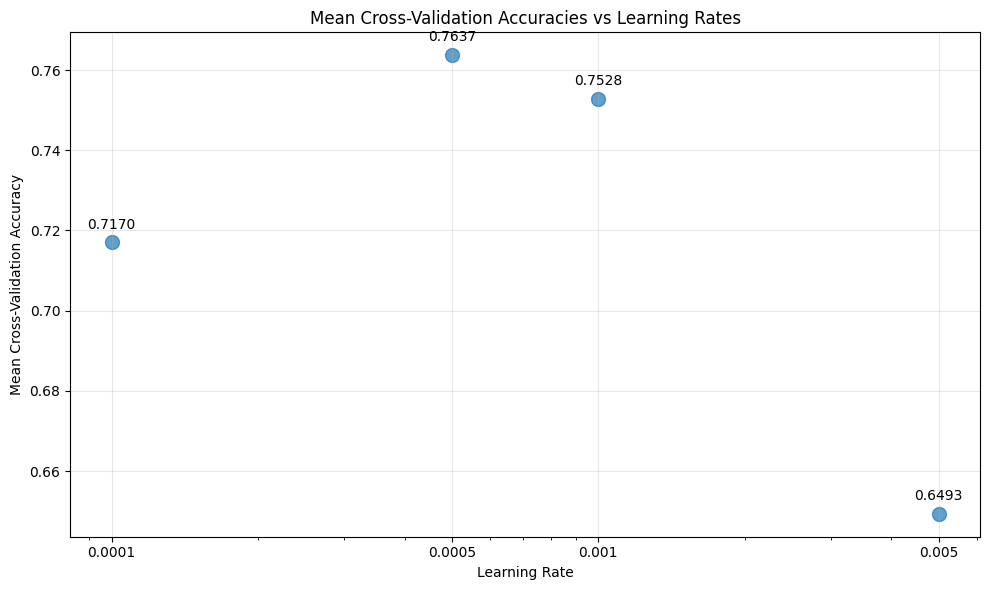

Mean Cross-Validation Accuracies:
Learning Rate 0.0001: 0.7170
Learning Rate 0.0005: 0.7637
Learning Rate 0.001: 0.7528
Learning Rate 0.005: 0.6493


In [11]:
# Calculate mean cross-validation accuracies for each learning rate
mean_accuracies = {learning_rate: np.mean(accuracies) for learning_rate, accuracies in cross_validation_accuracies.items()}

# Sort for cleaner plotting
x_vals = sorted(mean_accuracies.keys())
y_vals = [mean_accuracies[lr] for lr in x_vals]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, s=100, alpha=0.7)

plt.xlabel('Learning Rate')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracies vs Learning Rates')
plt.grid(True, alpha=0.3)
plt.xscale('log')

# Force one tick label per learning-rate point
plt.xticks(x_vals, [f"{lr:.4g}" for lr in x_vals])

# Add value labels on each point
for lr, acc in zip(x_vals, y_vals):
    plt.annotate(f'{acc:.4f}', (lr, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print("Mean Cross-Validation Accuracies:")
for lr, acc in zip(x_vals, y_vals):
    print(f"Learning Rate {lr}: {acc:.4f}")

---

## 5. Optimal Learning Rate

Create a table of number of epochs required to reach convergence against different learning rates. Select the optimal learning rate and state a reason for your selection.

In [15]:
mean_times = {learning_rate: np.mean(times) for learning_rate, times in cross_validation_times.items()}

df = pd.DataFrame({
    'Learning Rate'         : list(mean_times.keys()),
    'Mean Time (seconds)'   : list(mean_times.values()),
    'Accuracy'              : list(mean_accuracies.values())
})

df

,Learning Rate,Mean Time (seconds),Accuracy
0,0.0010,2.268963,0.752841
1,0.0050,1.526537,0.649333
2,0.0001,4.994705,0.717012
3,0.0005,2.848840,0.763707


**Optimal Learning Rate = 0.0005**

It resulted in the highest accuracy among all 4 learning rates. On the other hand, learning rate of 0.0010 sacrifised accuracy slightly with faster mean time to convergence. While the difference in time is insignificant here, if the dataset happens to be very large, learning rate of 0.00010 can be considered as well.